#**PRACTICA NLP REVIEWS HOME AND KITCHEN**

# **Descarga y exploración del corpus**

**1. Instalación y Carga de Librerías**

Instalo las librerías necesarias para procesamiento de lenguaje natural (SpaCy, nltk), modelos de Word Embeddings (gensim), análisis de datos (pandas), y visualización (wordcloud, matplotlib, seaborn).

E Importo las librerías necesarias para el análisis de datos, procesamiento de texto, visualización y entrenamiento de modelos.

In [27]:
# Instalación de librerías necesarias
!pip install datasets gensim wordcloud nltk scikit-learn spacy
!python -m spacy download en_core_web_sm

# Importación de librerías
import pandas as pd
import gzip
import json
import spacy
nlp = spacy.load("en_core_web_sm")  # Carga el modelo en inglés
from wordcloud import WordCloud
import numpy as np
from nltk import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from sklearn.decomposition import PCA


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


**2. Carga y Exploración Inicial del Dataset**

En esta parte, descargo y exploro el conjunto de datos, desde un archivo comprimdo JSON para que muestre información básica del dataframe, como primeras filas y valores nulos

In [21]:
# Ruta del archivo en Google Colab
file_path = "/content/reviews_Home_and_Kitchen_5.json.gz"

# Función para cargar JSON comprimido
def load_json_gz(file_path, nrows=None):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        data = [json.loads(line) for i, line in enumerate(f) if nrows is None or i < nrows]
    return pd.DataFrame(data)

# Cargar el dataset (ejemplo con 10,000 filas para pruebas rápidas)
df = load_json_gz(file_path, nrows=10000)

# Mostrar primeras filas
display(df.head())

# Información del dataset
df.info()

# Verificación de valores nulos
df.isnull().sum()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10000 non-null  object 
 1   asin            10000 non-null  object 
 2   reviewerName    9820 non-null   object 
 3   helpful         10000 non-null  object 
 4   reviewText      10000 non-null  object 
 5   overall         10000 non-null  float64
 6   summary         10000 non-null  object 
 7   unixReviewTime  10000 non-null  int64  
 8   reviewTime      10000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 703.3+ KB


,0
reviewerID,0
asin,0
reviewerName,180
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0


**2.1: Selección y Preparación del Dataset**

Filtro solo las columnas relevantes (reviewText y overall) y compruebo nuevamente los valores nulos y la información reducida del dataset.

**¿Por que escojo estas dos columnas?**

reviewText: Porque contiene la opinión del usuario, que es el texto que se preprocesa y se usa para predecir el sentimiento.

overall: Porque representa el sentimiento de la reseña.

**¿Por qué elimino las demás columnas?**

reviewerID: No aporta información útil sobre el sentimiento. Solo identifica al usuario.

asin: Es el código del producto, no influye en el sentimiento de la reseña.

reviewerName: Puede estar vacío (NaN). Además, el nombre del usuario no afecta el sentimiento.

helpful: Es el número de votos útiles, pero no influye en si la reseña es positiva o negativa.

summary: Es un resumen corto de la reseña, pero reviewText ya contiene la opinión completa.



In [22]:
# Seleccionar solo las columnas necesarias para el análisis de sentimiento
df = df[['reviewText', 'overall']]

# Verificación de valores nulos después del filtrado
print("\nValores nulos después del filtrado de columnas:")
print(df.isnull().sum())

# Mostrar las primeras filas del nuevo dataset reducido
display(df.head())

# Información del dataset después del filtrado
df.info()



Valores nulos después del filtrado de columnas:
reviewText    0
overall       0
dtype: int64


,reviewText,overall
0,My daughter wanted this book and the price on ...,5.0
1,I bought this zoku quick pop for my daughterr ...,5.0
2,There is no shortage of pop recipes available ...,4.0
3,This book is a must have if you get a Zoku (wh...,5.0
4,This cookbook is great. I have really enjoyed...,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  10000 non-null  object 
 1   overall     10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


**3. Cardinalidad del vocabulario**

Cálculo de la cardinalidad del vocabulario sin preprocesamiento
Se extraen todas las palabras del conjunto de reseñas y se cuentan las únicas.
No se realiza tokenización, lematización ni eliminación de stopwords,
simplemente se identifican las palabras únicas en el texto original.

In [23]:
# Calcular la cardinalidad del vocabulario
all_words = " ".join(df["reviewText"].dropna()).split()  # Concatenar todas las reviews y dividir en palabras
word_counts = Counter(all_words)  # Contar la frecuencia de cada palabra
num_unique_words = len(word_counts)  # Número de palabras únicas

# Mostrar el resultado
print(f"Número total de palabras únicas en el dataset (sin preprocesamiento): {num_unique_words}")

Número total de palabras únicas en el dataset (sin preprocesamiento): 51534


**4. Distribución de Clases en las Reviews**

Aquí visualizamos cómo se distribuyen las reviews entre positivas y negativas.

Uso la columna 'overall', que representa la calificación en estrellas de las reviews. Transformo 'overall' en una variable binaria de sentimiento (positivo o negativo).

4 o 5 estrellas → Positivo (1)

1, 2 o 3 estrellas → Negativo (0)

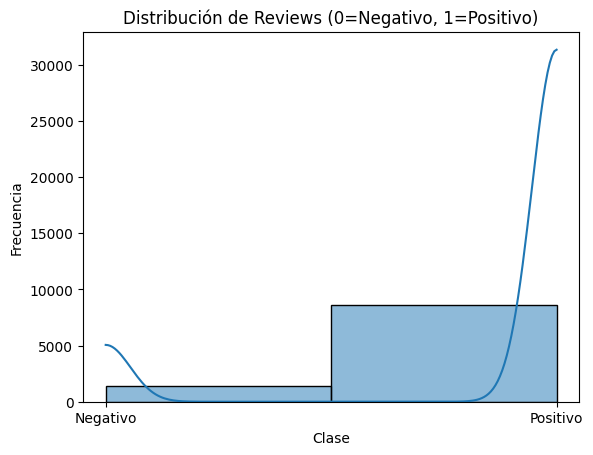

Número de reviews negativas: 1390
Número de reviews positivas: 8610


In [24]:
# Filtrar solo las columnas necesarias para análisis de sentimiento
df = df[['reviewText', 'overall']]
df = df.dropna(subset=['reviewText'])  # Eliminar valores nulos en reviewText

# Transformar la puntuación en variable binaria (0 = negativa, 1 = positiva)
df['sentiment'] = df['overall'].apply(lambda x: 1 if x >= 4 else 0)

# Visualización de la distribución de etiquetas
sns.histplot(df['sentiment'], bins=2, kde=True)
plt.title("Distribución de Reviews (0=Negativo, 1=Positivo)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks(ticks=[0, 1], labels=["Negativo", "Positivo"])
plt.show()

# Conteo de reviews positivas y negativas
num_negativas = df[df['sentiment'] == 0].shape[0]
num_positivas = df[df['sentiment'] == 1].shape[0]

print(f"Número de reviews negativas: {num_negativas}")
print(f"Número de reviews positivas: {num_positivas}")



**Resultado**: Se observa un desbalance en la cantidad de reseñas, donde la mayoría son positivas (8,610) frente a un menor número de reseñas negativas (1,390). Esto es importante para el posterior entrenamiento del modelo, ya que un desbalance de clases puede afectar la capacidad del modelo para aprender correctamente la categoría minoritaria.

Se podría considerar alguna técnica de balanceo de clases en la fase de modelado.